# 2026 Land-Doig MIP Competition Tutorial: Local Search on GPU

Christian Tjandraatmadja (ctjandra@google.com) and the 2026 Land-Doig MIP
Competition Committee

*Last updated: Dec 17, 2025*

--------------------------------------------------------------------------------

# Part 1: Introduction + a CPU implementation of feasibility jump

## Introduction

The main goal of this tutorial is to provide an example of a GPU algorithm for MIP heuristic, particularly considering challenges in the scope of MIP. This tutorial was created for the 2026 Land-Doig MIP Competition on GPU heuristics for MIP, though it is hopefully useful for others beyond this context.

This tutorial is intended to demonstrate some GPU implementations by example, rather than from first principles. For those, there are tutorials from other sources in the [competition page](https://www.mixedinteger.org/2026/competition). It is highly recommended for readers to at least familiarize with the [basic programming model for GPUs](https://docs.nvidia.com/cuda/cuda-programming-guide/01-introduction/programming-model.html) before going through this tutorial.

We also provide another shorter tutorial with a 2-opt example in C++ in the [competition page](https://www.mixedinteger.org/2026/competition).

This tutorial is divided into three parts:

1.  Part 1: Introduction + a CPU implementation of feasibility jump;
2.  Part 2: A GPU implementation of feasibility jump via Numba;
3.  Part 3: A GPU implementation of feasibility jump via JAX;

This is Part 1 and you can find the other parts in the [competition page](https://www.mixedinteger.org/2026/competition). If you are not be interested in the CPU implementation, we recommend that you still skim this one as we describe the algorithm and establish assumptions in this part.

**Non-goals:** This tutorial is not aimed at producing an efficient implementation
of feasibility jump, nor one that produces high-quality solutions. The version of feasibility jump implemented here is simplified to make it easier to understand the process of
implementing a MIP heuristic on a GPU.

*For competition participants:* If any code in this tutorial might be useful for your submission, feel free to use it as you wish, but keep in mind the various simplifications that this tutorial does.

## Programming language and libraries

This tutorial assumes basic familarity with mixed-integer programming and with Python. We use the following language and libraries:

* **Python:** This tutorial is in Python mainly for convenience, but also because the Python GPU
library ecosystem is fairly mature and easy-to-use. We do not lose a lot of performance from using Python since GPU code is compiled to a lower level, though you do pay the cost of just-in-time (JIT) compilation. For competition participants, there are various options in different languages and you should consider trade-offs. In particular, if you are aiming for performance, C/C++ may the best bet, but you might be trading off prototyping speed depending on your language familiarity. While we will not cover other languages here, many of the principles will be similar. To learn CUDA in C++, we have also written a 2-opt example (found in the [competition page](https://www.mixedinteger.org/2026/competition)), and in addition we recommend [this external tutorial](https://www.youtube.com/watch?v=Sdjn9FOkhnA&list=PL5B692fm6--vWLhYPqLcEu6RF3hXjEyJr).

* **Numba:** There are various CUDA-level libraries for Python. We choose Numba here because it lets us dive into GPU kernels while still writing Python code, which might be closest to a C++ CUDA implementation at a Python level. Other options, such as CuPy, might be more suitable for algorithms that are particularly numpy-based, but we will not cover it in this tutorial.

* **JAX:** JAX and PyTorch, while geared towards machine learning, are convenient libraries to run linear algebra computations on GPU. One of their key features is automatic differentiation for training machine learning models, but they are still very useful even if you do not use that. The choice of JAX over PyTorch in this tutorial is solely based on the author's familiarity with the library; you should consider the trade-offs between them.

Ultimately, what is important are the ideas and obstacles when implementing a GPU algorithm, and less so the actual library being used to do the implementation. We hope that this tutorial will be useful even if you choose a different language and/or library.

## Colab logistics

You can connect to a GPU by changing the runtime on the top right menu to a GPU.
You can use Colab's free-tier GPU, but be careful that you consume it as long as
you are connected to the runtime, so you might want to connect to the runtime only when you are ready to run the code. You can of course copy and paste the code and run it elsewhere as you wish.

Part 1 does not require a GPU runtime, but the other parts do.

# Initial setup and utility functions

These hidden cells need to be run first for the tutorial. These same cells appear on all parts. They contain imports and some
utility functions that will be useful later in the tutorial (e.g. plotting).
This is not too important for the tutorial itself and you can run this cell
without looking, though you may want to take a quick glance at the imports that
we will be using.

In [2]:
import dataclasses
from typing import NamedTuple
import math

# Numba imports.
# Tip: If you need to debug Numba, uncomment below to use the CUDA simulator.
# https://numba.pydata.org/numba-doc/dev/cuda/simulator.html
# import os
# os.environ['NUMBA_ENABLE_CUDASIM'] = '1'
from numba import cuda, float64, int32

# JAX imports.
import jax
from jax.experimental import sparse
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np
import scipy  # For sparse matrices.

In [3]:
# Plotting code. You should probably ignore this.

def plot_polytope(A, b, vertices_for_shading, x_lim, y_lim):
  # Only two-dimensional problems.
  assert A.shape[1] == 2

  plt.figure(figsize=(8, 6))

  # Shade feasible region.
  if vertices_for_shading is not None:
    plt.fill(
        vertices_for_shading[:, 0],
        vertices_for_shading[:, 1],
        color='skyblue',
        alpha=0.5,
    )

  # Plot constraints.
  x_vals = np.linspace(x_lim[0], x_lim[1], 100)
  for i in range(len(b)):
    a1, a2 = A[i]
    if np.isclose(a2, 0):  # Vertical line.
      plt.axvline(b[i] / a1, color='k', linestyle='--', alpha=0.6)
    else:
      plt.plot(x_vals, (b[i] - a1 * x_vals) / a2, 'k--', alpha=0.6)

  # Get integer points in plot and check which ones are feasible.
  x_grid = np.arange(np.floor(x_lim[0]), np.ceil(x_lim[1]) + 1)
  y_grid = np.arange(np.floor(y_lim[0]), np.ceil(y_lim[1]) + 1)
  xx, yy = np.meshgrid(x_grid, y_grid)
  points = np.c_[xx.ravel(), yy.ravel()]
  is_feasible = np.all(A @ points.T <= b[:, None], axis=0)

  # Plot integer points.
  plt.scatter(
      points[~is_feasible, 0], points[~is_feasible, 1], c='lightgray', s=10
  )
  plt.scatter(
      points[is_feasible, 0],
      points[is_feasible, 1],
      c='red',
      s=30,
  )

  # Create plot.
  plt.xlim(x_lim)
  plt.ylim(y_lim)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.grid(True, alpha=0.3)
  plt.show()


# These violation functions will be explained (and repeated) later.
def compute_single_constraint_violation(
    x, A, critical_delta_matrix, weights, i, j
):
  # Single-constraint violation function (violation of constraint i for var. j):
  #   v_i(j) = max(0, sign(A[i][j]) * w[i] * (x - B[i][j]))
  term = np.sign(A[i, j]) * weights[i] * (x - critical_delta_matrix[i, j])
  return np.maximum(0, term)


def compute_total_violation(x, A, critical_delta_matrix, weights, var_ind):
  # Total violation function (aggregated violation for var. j):
  #   v(j) = sum_i max(0, sign(A[i][j]) * w[i] * (x - B[i][j]))
  all_row_indices = np.arange(A.shape[0])[:, None]
  all_violations = compute_single_constraint_violation(
      x, A, critical_delta_matrix, weights, all_row_indices, var_ind
  )
  return np.sum(all_violations, axis=0)


def plot_individual_fj_violation_functions(
    A, breakpoint_matrix, weights, cons_strs, delta_lb, delta_ub
):
  num_rows, num_cols = A.shape
  _, axes = plt.subplots(
      num_rows,
      num_cols,
      figsize=(4 * num_cols, 3 * num_rows),
      constrained_layout=True,
  )
  x = np.linspace(delta_lb, delta_ub, 100)
  for i in range(num_rows):
    for j in range(num_cols):
      ax = axes[i, j]
      y = compute_single_constraint_violation(
          x, A, breakpoint_matrix, weights, i, j
      )
      ax.plot(x, y, color='orange')
      ax.set_title(f'{cons_strs[i]}, var: x[{j}], w={weights[i]:.2f}')
      ax.grid(True)
      ax.set_xlim(delta_lb[j], delta_ub[j])
      ax.set_ylim(-1, 6)
  plt.show()


def plot_total_fj_violation(
    A,
    breakpoint_matrix,
    weights,
    delta_lb,
    delta_ub,
    target_deltas=None,
    scores=None,
):
  _, num_cols = A.shape
  if num_cols > 4:
    num_cols = 4
    print(f'Plotting only for the first 4 columns out of {num_cols}')
  _, axes = plt.subplots(
      1,
      num_cols,
      figsize=(4 * num_cols, 3),
      constrained_layout=True,
  )
  for j in range(num_cols):
    ax = axes[j]
    x = np.linspace(delta_lb[j], delta_ub[j], 100)
    y = compute_total_violation(x, A, breakpoint_matrix, weights, j)
    var_name = f'x[{j}]'
    ax.plot(x, y, color='b')
    ax.set_title(f'var: {var_name}')
    ax.grid(True)
    ax.set_xlim(delta_lb[j], delta_ub[j])
    ax.set_ylim(bottom=-1)
    ax.set_xlabel(f'Delta for {var_name}')
    ax.set_ylabel('Violation')
    ax.axvline(0, color='red', linestyle='--')
    if target_deltas:
      ax.axvline(target_deltas[j], color='red', linestyle='-')
      ax.annotate(
          '',
          xy=(target_deltas[j], 0),
          xytext=(0, 0),
          arrowprops=dict(
              facecolor='red', edgecolor='red', arrowstyle='-|>', lw=1.5
          ),
          annotation_clip=False,
      )
      if scores and scores[j] != 0:
        ax.annotate(
            f'delta = {target_deltas[j]}\nscore = {scores[j]}',
            xy=(target_deltas[j] / 2, 0),
            xytext=(0, -5),
            textcoords='offset points',
            ha='center',
            va='top',
            color='red',
            fontsize=8,
            annotation_clip=False,
        )
  plt.show()

# Problem data structure definitions

In the competition, we are interested in general mixed-integer linear
programming problems. However, to simplify the scope of this tutorial, we will
make some assumptions:

1.  In this tutorial, we consider pure integer problems, with no continuous variables. This
    assumption is to make the tutorial simpler; competition participants
    **must** consider the mixed-integer case.
2.  All variables are bounded. This is typically not an important assumption for
    a heuristic, as may simply end up with a solution inside artificial bounds
    if your problem is unbounded.
3.  All constraints are of the form Ax <= b. This is also not a significant
    assumption as any set of linear constraints can be transformed to Ax <= b, but implementations
    might be more efficient if they directly consider constraints bounded from
    both sides.
4.  We drop the constant in the objective function for simplicity. Competition
    participants **must** consider it, but this is easy to handle and can be
    considered in a pre/postprocessing step.

We write a simple dataclass for such a type of instance below, and use it
throughout all parts of the the tutorial.

In Parts 2 and 3, these data structures will be moved to the hidden cell in the "Initial setup and utility functions" section.

In [4]:
@dataclasses.dataclass
class IPInstance:
  """Data structure to store a (pure) Integer Programming instance.

    minimize c^T x
      Ax <= b
      var_lb <= x <= var_ub
            x integer

  All vectors are stored as dense numpy vectors. The matrix A is stored as
  a sparse matrix in compressed sparse row (CSR) format.
  """

  c: np.ndarray
  A: scipy.sparse.csr_matrix
  b: np.ndarray
  var_lb: np.ndarray
  var_ub: np.ndarray

# Small running example

We will work with a simple two-dimensional instance as a running example:

$$
\min -x - y\\[1em]
-x - 2.5y \leq -3.5\\
x + 2.5y \leq 12\\
-3x + y \leq 0\\
x \leq 2.5\\[1em]
x \in [0, 3], y \in [0, 5]\\
x \in \mathbb{Z}, y \in \mathbb{Z}
$$

Note that we treat the constraint $x \leq 2.5$ (which could actually be a bound)
as an explicit constraint mostly to cover the case of a zero coefficient in the
constraint matrix. The cell below plots a visualization of this problem.

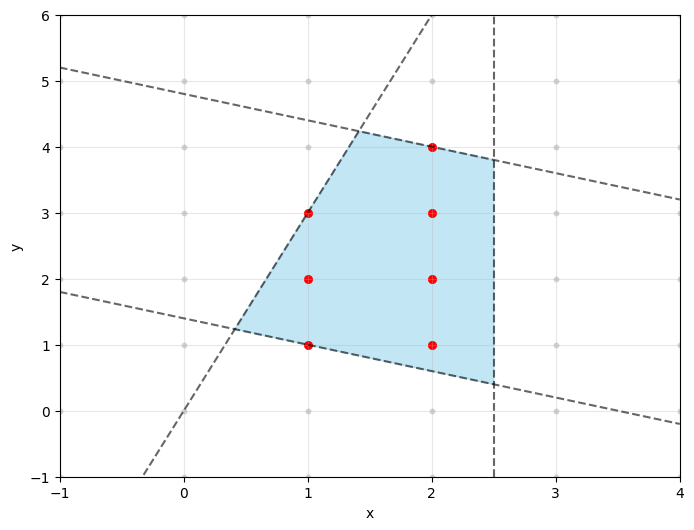

In [5]:
SIMPLE_IP = IPInstance(
    c=np.array([-1, -1]),
    A=scipy.sparse.csr_matrix(np.array([[-1, -2.5], [1, 2.5], [-3, 1], [1, 0]])),
    b=np.array([-3.5, 12, 0, 2.5]),
    var_lb=np.array([0, 0]),
    var_ub=np.array([3, 5]),
)

# To make plotting easier, we manually pass vertices for shading the polytope.
SIMPLE_IP_LINEAR_RELAXATION_VERTICES = np.array([
    [7 / 17, 21 / 17],
    [2.5, 0.4],
    [2.5, 3.8],
    [24 / 17, 72 / 17],
])
# Plotting code is in utility function cell.
plot_polytope(
    np.asarray(SIMPLE_IP.A.todense()),
    SIMPLE_IP.b,
    SIMPLE_IP_LINEAR_RELAXATION_VERTICES,
    x_lim=(SIMPLE_IP.var_lb[0] - 1, SIMPLE_IP.var_ub[0] + 1),
    y_lim=(SIMPLE_IP.var_lb[1] - 1, SIMPLE_IP.var_ub[1] + 1),
)

# What is the feasibility jump heuristic?

## Introduction

Feasibility jump is a **guided local search heuristic aimed at finding an
initial feasible solution quickly**. It was the winner of the first MIP Computational
Competition in 2022, which challenged participants to produce LP-free heuristics for MIP. Versions of
it are currently implemented in many modern MIP solvers. We will describe the
heuristic in this tutorial, but we recommend readers to follow along with the
original paper:

*   Luteberget, B. and Sartor, G., 2023. *Feasibility Jump: an LP-free
    Lagrangian MIP heuristic.* Mathematical Programming Computation, 15(2),
    pp.365-388.

We choose this heuristic as it is relatively simple with a structure that is familiar to many -- local search -- and yet it offers some interesting challenges for a GPU implementation. And of course, lightly, as a nudge to its origins in this competition. :)

We highlight that this tutorial covers a **simplified version** of feasibility jump. It is:

1. *Simpler than MIP solver implementations of the heuristic:* Given its primary goal of finding quick feasible solutions and not as much quality, naive implementations tend to get stuck in poor local optima, including the one in this tutorial. We do not attempt to make it particularly effective, and thus **we will not be concerned about solution quality in this tutorial**. MIP solvers often make them more practical with techniques typical of local search: perturbations, restarts, better weight updates, etc. A well-engineered implementation can be quite effective in producing a first feasible solution very quickly, but this tutorial does not provide one.

2. *Simpler even than the original paper:* To illustrate GPU parallelization, **we take a "brute-force" approach (unlike in the original algorithm)**: we compute scores not only for all variables, but also for all candidate values to move to for each variable. The original algorithm is more careful about both: in fact, the scoring function for candidate values is designed to be piecewise linear convex so it is easy to optimize over. Taking advantage of that structure is out of scope of this tutorial, though it should be doable in a GPU implementation.

Despite simplifications, the local search structure of this algorithm is a common structure and we hope this choice of heuristic highlights some strategies and challenges in writing a local search algorithm for GPUs.

## The algorithm

As a local search algorithm, feasibility jump **iteratively selects a variable and assigns it a new value in
each iteration** ("jumps to a new value"). It is a **guided** local search algorithm as it uses weights to balance how the constraints will factor into the scoring function.

The overall local search framework is as follows:

```
initialize solution x and weights w
while stopping condition is not true:
    deltas, scores ← compute_candidate_deltas_and_scores(instance, x, w)
    selected_var ← argmin(scores)
    x[selected_var] ← x[selected_var] + deltas[selected_var]
    w ← update_weights(instance, x, w)
```

*Note: A difference between the original paper and this tutorial is that we work with "deltas" (variable changes) instead of the value the variable
jumps to. This slightly simplifies some computation, as we see below.*

For this tutorial, we will simply choose to start from the zero point, clipped to bounds. In fact, this is what some MIP solvers do. In theory, we can start from any initial solution, feasible or infeasible.

The bulk of the algorithm is defining what the candidate deltas and scores will
be. Given that the algorithm was initially designed to find any feasible
solution quickly, **for each variable, it determines the value (or delta) that
minimizes a measure of constraint violation**, and then across all variables, it **selects the variable that most decreases the constraint violation**.

We now describe in more detail the three main ingredients of the algorithm that occur in each iteration (most of the algorithm is in the first step):

1. Given a variable $x_j$, what value should it be set to?
2. Across all variables, which variable $x_j$ should we select to move?
3. How should weights $w$ be updated?

### 1. Given a variable $x_j$, what value should it be set to?

In each iteration, we start with a solution $\bar{x}$ and we only want to move one variable, $x_j$. We start by considering one constraint $i$ at a time.

#### Violation function for a single constraint $i$ and variable $j$

The algorithm defines a measure of constraint violation per variable $j$ and per constraint $i$ (denoted $g_{ij}$ in the paper except for the weight multiplier). The violation function is defined to be the **distance from $\bar{x}$ to the closest solution satisfying constraint $i$ by moving only $x_j$**. Given our assumption that all linear constraints are one-sided, this is a 1d piecewise linear function with two pieces: it has value zero for points that satisfy the constraint $i$, and otherwise a linear distance for points that do not. The figure below illustrates this.

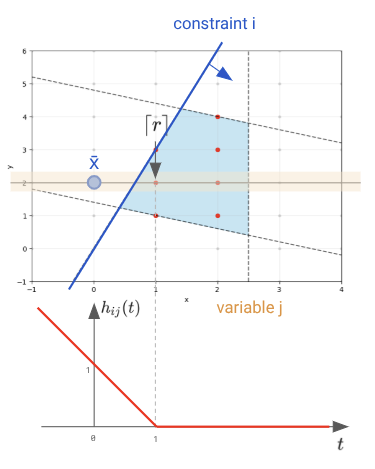

To write the mathematical expression, we need to find the integer point that satisfies the constraint and is closest to its hyperplane. Given that all values are fixed to $\bar{x}$ except $x_j$, let $r$ be the $x_j$ value of the point that intersects the hyperplane, which satisfies:

$$
\sum_{k \neq j}a_{ik} \bar{x}_k + a_{ij}r = b_i
$$

that is,
$$
r = \frac{b_i - \sum_{k \neq j}a_{ik} \bar{x}_k}{a_{ij}}
$$

The "first" integer point satisfying the constraint depends on the side of the constraint. We take the floor if the constraint points backwards (i.e. $a_{ij} > 0$ for $\leq$ constraints) or the ceiling otherwise. We are assuming in this tutorial that all variables are integer, but if $x_j$ were continuous, we simply skip the rounding.

$$
t_{ij} =
\begin{cases}
\lfloor r \rfloor & \text{if $a_{ij} > 0$}\\
\lceil r \rceil & \text{if $a_{ij} < 0$}\\
\end{cases}
$$

The $t_{ij}$ will then be the breakpoint of the two-piece piecewise linear function: one side will be zero, and the other side will be the distance to $t_{ij}$. This also depends on the side of the constraint. (Note: $h_{ij}$ is the unweighted version of $g_{ij}$ denoted in the paper.)

$$
h_{ij}(t) =
\begin{cases}
\max\{0, t - t_{ij}\} & \text{if $a_{ij} > 0$}\\
\max\{0, t_{ij} - t\} & \text{if $a_{ij} < 0$}\\
\end{cases}
$$

A difference in our tutorial is that we define this function in terms of delta change, instead of the actual value to jump to. The reason why this simplifies is that we do not need to exclude $\bar{x}_j$ in the definition of $r$. We can define residuals $\bar{r} = b - A\bar{x}$, which we compute once per iteration, and define the function in terms of that. You can check that $\hat{h}_{ij}$ is a simple horizontal shift of the function $h_{ij}$.

$$
d_{ij} =
\begin{cases}
\lfloor\frac{\bar{r}_i}{a_{ij}}\rfloor\ & \text{if $a_{ij} > 0$}\\
\lceil\frac{\bar{r}_i}{a_{ij}}\rceil & \text{if $a_{ij} < 0$}\\
\end{cases}
$$

$$
\hat{h}_{ij}(\Delta) =
\begin{cases}
\max\{0, \Delta - d_{ij}\} & \text{if $a_{ij} > 0$}\\
\max\{0, d_{ij} - \Delta\} & \text{if $a_{ij} < 0$}\\
\end{cases}
$$

The values $t_{ij}$ above are called critical values in the paper, and thus **we will call $d_{ij}$ the critical deltas**. They are the breakpoints in the violation function, and we define one per nonzero $a_{ij}$.

#### Total violation function per variable $j$

The algorithm aggregates the per-constraint violation functions by a simple weighted linear combination (assuming nonnegative weights):

$$
\hat{G}_j(\Delta) = \sum_{i : a_{ij} \neq 0} w_i \hat{h}_{ij}(\Delta)
$$

The weights $w_i$ used are per constraint, and updated at each iteration.  They signal how much impact a constraint should have in its violation function, relative to other constraints.

The $\bar{\Delta}_j$ that we choose for variable $x_j$ in each iteration is the one that minimizes this function:

$$
\bar{\Delta}_j = \arg \min \hat{G}_j(\Delta)
$$

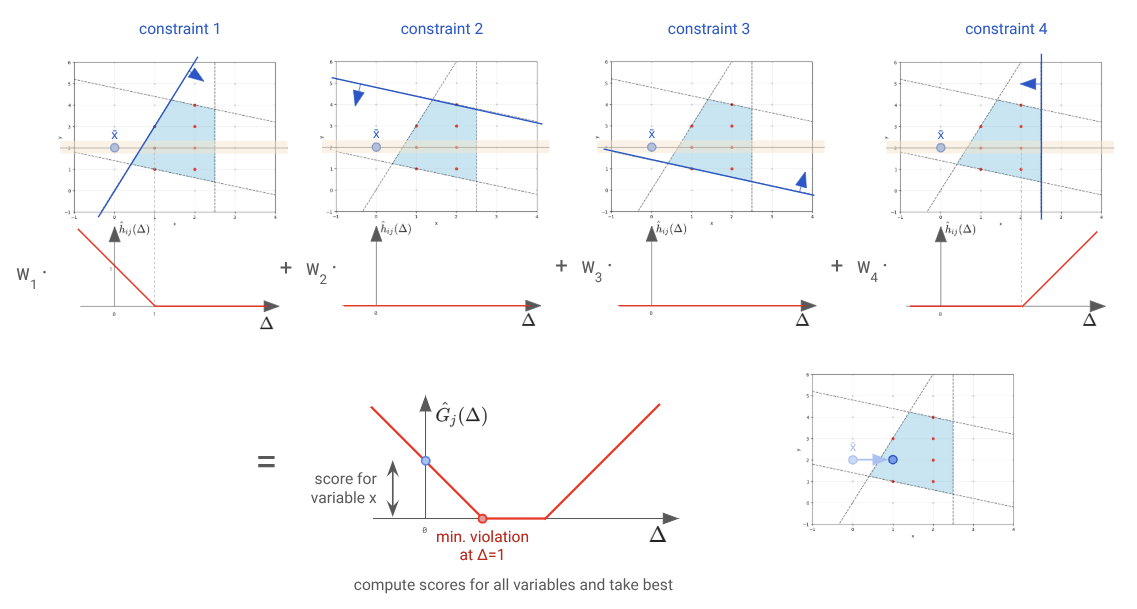

An important property of $\hat{G}_j$ is that it is a **1d piecewise linear convex function**, given that it is a conic combination of piecewise linear convex functions. Therefore, minimizing $\hat{G}_j(\Delta)$ is easy: the paper sorts the critical deltas (breakpoints of the function), and identifies the one where the slope is increasing. However, in this tutorial we will not do that to highlight GPU parallelization: **we will compute the violation function value for all critical deltas within bounds (plus the bounds themselves and zero) in parallel, and take the smallest one**, using smallest absolute value of delta as tie-breaker (i.e. closest to original solution). This makes the computation $O(n^2)$ instead of $O(n \log n)$. There are ways to emulate the $O(n \log n)$ algorithm on a GPU, but we will leave it outside the scope of this tutorial. Furthermore, this also means that the implementation in this tutorial can be adapted to other 1d violation functions that are not necessarily convex.

Finally, we remark that in real implementations, one can shortcut binary variables because there is only one other value to move to. We will ignore that in our tutorial implementation.


### 2. Across all variables, which variable $x_j$ should we select to move?

The algorithm **selects the variable that decreases their violation the most**, following the violation measure above. Note that for the $\Delta$-parameterized function, the violation for the current solution is simply $\hat{G}_j(0)$, so we take the difference between that and the minimum violation.

$$
\hat{j} = \arg \min_j \hat{G}_j(0) - \hat{G}_j(\bar{\Delta}_j)
$$


### 3. How should weights $w$ be updated?

The paper proposes a very simple weight update: **we increase weights by one for each violated constraint in the new solution**. This increases the importance of satisfying the more violated constraints.

$$
\bar{w}_i =
\begin{cases}
w_i & \text{if $\sum_i a_{ij} \bar{x}_j \leq b_i$}\\
w_i + 1 & \text{otherwise}\\
\end{cases}
$$

There may be better ways to update weights, but we leave it outside the scope of this tutorial.

### Objective constraint

As an addition to the algorithm, the paper suggests adding an objective constraint if one is interested in better objective values. We include that in the implementation in this tutorial.

The idea is simple: if our problem is to $\min c^\top x$, **we add to the constraints a constraint $c^\top x \leq \theta$ where $\theta$ is slightly below the best objective value from a feasible solution found so far**. This constraint is treated the same as the other in the algorithm, with the only difference that its right-hand side needs to be updated every time we find a better feasible solution. We initialize $\theta$ with infinity and it only gets updated when the first feasible solution is found. This helps push the solution to solutions with better objective values.

### Final notes

We remark that the paper actually suggests against computing all possible jump
values for all variables, not only because it can get too expensive, but also
because the paper authors do not see a lot of benefit from doing that. That
said, we will do that anyway since we want to illustrate GPU parallelization for
local search in this tutorial, even if it may not be the most effective use of
GPU.

In pseudocode, this is what the main loop will look like at a high level for all implementations. We use
the same function names in the pseudocode as we will in the implementation. Note that we update the residuals iteratively, which might incur some loss of numerical precision which we will not worry about in this tutorial (in practice, one might use e.g. Kahan summation).

```
initialize solution x to zero (projected to bounds)
initialize weights w to ones
extend A and b with objective constraint c^T x <= B, starting at B = +inf
residuals ← b - Ax
while x has changed or iteration limit is not hit:
    update objective constraint
    critical_deltas ← compute_critical_deltas(A, residuals)
    deltas, scores ← compute_candidate_deltas_and_scores(A, critical_deltas, w)
    selected_var ← argmin(scores)
    x[selected_var] ← x[selected_var] + deltas[selected_var]
    w ← update_weights(x, w)
    residuals ← residuals - A[:, selected_var] * deltas[selected_var]
```


# A vectorized CPU implementation with numpy

This section provides a first CPU implementation for the simplified feasibility jump algorithm, using numpy and vectorized operations. Furthermore, this section highlights the importance of using sparse operations for MIP algorithms.

This is intended to help readers understand the structure of the algorithm in a more traditional setting. Additionally, Part 1 explains the implementation step-by-step, whereas in Parts 2 and 3 we will skip that and assume the reader understands the structure of the algorithm. In particular, given the importance of sparsity in the context of MIP, this section also gives a gentler introduction on sparse operations without needing to worry about GPU for now. For readers eager to see a GPU implementation, we suggest at least skimming through this to understand the overall structure.

We write both a dense and sparse implementation of the algorithm. We assume the reader is familiar with numpy vectorization and broadcasting.

## Sparse data structures

In the context of MIP, whether in CPU or GPU, it is almost inevitable to need to handle sparsity, as typical MIP instances have sparse coefficient matrices. Even a dense GPU implementation is likely to be less efficient than a sparse CPU implementation if you are dealing with often-sparse MIP instances. To do so, it is important to know how sparse matrices are typically stored.

In this tutorial, we will use mostly Compressed Sparse Column (CSC), though we originally have the instance in Compressed Sparse Row (CSR). A short description is below, but this is easier to understand with a picture: we recommend taking a look at [this link](https://docs.nvidia.com/cuda/cusparse/#matrix-formats), which also describes other sparse formats.

The general idea of CSR (CSC) is that we have three arrays per sparse matrix:
1. an array with all the nonzero data in row-major (column-major) order (size = # nonzeros);
2. an array with the column (row) indices for each of the data values (size = # nonzeros);
3. an array with indices of the above two arrays indicating where each row (column) starts (size = # rows (cols)).

In our implementation, **we use CSC as we are generally interested in parallelizing over columns**, since we want to compute violations and a score for each of them. It also helps that the matrix is stored in column-major order, as it is more efficient to access memory contiguously. We will also use CSC in our GPU implementations in Parts 2 and 3. In some situations, one might even choose to store copies of the data in two different formats, sacrificing memory for efficiency.

## Utility functions and constants

The next cell has functions used in both implementations. In this case, these are the initial solution that we start from, and an utility function to extend A and b to include the objective constraint, starting from unbounded.

In [6]:
def initialize_solution(instance: IPInstance) -> np.ndarray:
  """Return the zero point, projected to variable bounds if outside them."""
  init_x = np.zeros(instance.A.shape[1])
  init_x = np.maximum(init_x, instance.var_lb)
  init_x = np.minimum(init_x, instance.var_ub)
  return init_x


def extend_A_b_with_objective_constraint(
    instance: IPInstance
) -> tuple[scipy.sparse.spmatrix, np.ndarray]:
  """Returns A and b with an additional row for objective constraint."""
  c_sparse = scipy.sparse.csr_matrix(instance.c)
  A_ext = scipy.sparse.vstack((instance.A, c_sparse), format='csr')
  b_ext = np.append(instance.b, np.inf)
  return A_ext, b_ext


# The right-hand side of objective constraint will be the best primal bound
# minus this value. This emulates a strict inequality, though in this case it
# does not need to be necessarily small if we want to incentivize larger jumps.
OBJECTIVE_PUSH_VALUE = 1e-3

# Absolute tolerance for feasibility.
FEASIBILITY_TOLERANCE = 1e-6

## Implementation (both dense and sparse)

Colab tip: You can run all cells at once by hiding this section (arrow to the left of the header), clicking run, then unhiding it. This section only contains function definitions and does not run the heuristic.

---

In `compute_critical_deltas`, we compute:

$$
d_{ij} =
\begin{cases}
\lfloor\frac{\bar{r}_i}{a_{ij}}\rfloor\ & \text{if $a_{ij} > 0$}\\
\lceil\frac{\bar{r}_i}{a_{ij}}\rceil & \text{if $a_{ij} < 0$}\\
\end{cases}
$$

assuming that the residuals are already computed (we iteratively update them later). We store this as a matrix of the same shape as A (dense or sparse).

Note the similarities and differences between the dense and sparse version. The dense version is fairly direct with the use of broadcasting. In the sparse version, we first collect the row indices that match with the data, and then `residuals[row_indices]` gathers residuals for the rows corresponding to each nonzero entry, repeating as needed. For example, if `inds = [1, 3, 3]`, then `r[inds] = [r[1], r[3], r[3]]`. Then, we divide over all nonzeros in A. We can think of these operations as occurring on long arrays.

Gather operations like the above (and their inverse, scatter operations) can sometimes be bottlenecks especially for GPU algorithms, as they involve indirect memory accesses. GPU threads are most efficient when they are performing computation over contiguous memory blocks, which is not the case with these operations. That said, while ideally it is best to work with contiguous memory, gather and scatter are very common operations and modern GPUs are well-optimized to handle them, and thus it is often perfectly fine to use them with GPUs.

In [7]:
def compute_critical_deltas_cpu_dense(
    A: np.ndarray, residuals: np.ndarray
) -> np.ndarray:
  """Compute critical deltas for each nonzero A_ij.

    d_ij = floor(r_i / A_ij)  if A_ij > 0
           ceil(r_i / A_ij)   if A_ij < 0

  The result is a matrix of the same size as A. In this dense version, d_ij = 0
  when A_ij = 0.
  """
  # Ignore divisions by zero as we overwrite them below.
  with np.errstate(divide='ignore', invalid='ignore'):
    ratio_matrix = residuals[:, None] / A
  critical_deltas = np.select(
      [A > 0, A < 0],
      [np.floor(ratio_matrix), np.ceil(ratio_matrix)],
      # Set to zero when A[i,j] = 0. This is technically unused, but in a dense
      # implementation, it is part of computation and multiplied by zero later.
      default=0.0,
  )
  return critical_deltas


def compute_critical_deltas_cpu_sparse(
    A: scipy.sparse.csc_matrix, residuals: np.ndarray
) -> scipy.sparse.csc_matrix:
  """Compute critical deltas for each nonzero A_ij.

    d_ij = floor(r_i / A_ij)  if A_ij > 0
           ceil(r_i / A_ij)   if A_ij < 0

  The result is a matrix of the same size as A. In this sparse version, we
  assume that we do not have zero entries in the nonzero data. Note that this
  is not guaranteed as a user can add them manually.
  """
  row_indices = A.indices
  # We make a hard assumption that A.data has no zeros.
  ratio_matrix = residuals[row_indices] / A.data
  critical_delta_data = np.select(
      [A.data > 0, A.data < 0],
      [np.floor(ratio_matrix), np.ceil(ratio_matrix)],
  )
  return scipy.sparse.csc_matrix(
      (critical_delta_data, A.indices, A.indptr), shape=A.shape
  )

In `compute_violations`, we take as input an array of `deltas`, and compute the total violation for all of those deltas. In other words, given $j$, `A`, `critical_deltas` $d_{ij}$, and `weights` $w$, and:

$$
\hat{h}_{ij}(\Delta) =
\begin{cases}
\max\{0, \Delta - d_{ij}\} & \text{if $a_{ij} > 0$}\\
\max\{0, d_{ij} - \Delta\} & \text{if $a_{ij} < 0$}\\
\end{cases}
$$

$$
\hat{G}_j(\Delta) = \sum_{i : a_{ij} \neq 0} w_i \hat{h}_{ij}(\Delta)
$$

then this function takes in $[\Delta_1, \Delta_2, \ldots, \Delta_k]$ and outputs $[\hat{G}_j(\Delta_1), \hat{G}_j(\Delta_2), \ldots, \hat{G}_j(\Delta_k)]$. These `deltas` will include not only the critical deltas (i.e. breakpoints of the piecewise linear function), but also the delta lower bound, delta upper bound, and zero.

Again, we can think of the sparse version as if we are computing only the relevant data over a long array.

In [8]:
def compute_violations_cpu_dense(
    deltas: np.ndarray,
    A: np.ndarray,
    critical_deltas: np.ndarray,
    weights: np.ndarray,
    var_idx: float,
) -> np.ndarray:
  """Computes the violation function for all `deltas` for a given column."""
  # Violation function:
  #   sum_i max(0, sign(A[i][j]) * w[i] * (deltas - cd[i][j]))
  row_indices = np.arange(A.shape[0])[:, None]
  terms = (
      np.sign(A[row_indices, var_idx])
      * weights[row_indices]
      * (deltas - critical_deltas[row_indices, var_idx])
  )
  all_violations = np.maximum(0, terms)
  return np.sum(all_violations, axis=0)


def compute_violations_cpu_sparse(
    deltas: np.ndarray,
    A_col: np.ndarray,
    critical_deltas_col: np.ndarray,
    weights_col: np.ndarray,
) -> np.ndarray:
  """Computes the violation function for all `deltas` for a given column."""
  # Note that we do not need to pass the column index here as we are given only
  # the relevant column data directly.
  # Violation function:
  #   sum_i max(0, sign(A_col[i]) * w[i] * (deltas - cd_col[i]))
  terms = (
      np.sign(A_col)[:, None]
      * weights_col[:, None]
      * (deltas[None, :] - critical_deltas_col[:, None])
  )
  all_violations = np.maximum(0, terms)
  return np.sum(all_violations, axis=0)

The third function that we write is `compute_best_deltas_and_scores`, which does the following:

For each column $j$:

1. Collect the critical deltas and bounds for which we want to compute violation, excluding those that fall outside bounds;
2. Compute violations for these deltas;
3. Take the delta with smallest violation across these violations (which is the global minimum as it includes all breakpoints), and as a tie-breaker, choose the delta closest to zero (i.e. stay close to the previous solution);
4. Compute the score, which is the difference between violations for a zero delta and the minimum;

Then return the best deltas and scores for all columns.

In this version, we only have one non-vectorized for loop (in each iteration), which is over columns. Not only there is significant complexity in this loop, but also in the sparse case, each column may have a different number of nonzeros. In fact, this can pose a challenge for GPU implementations, which we discuss in Parts 2 and 3.

Observe how we extract column data for a CSC matrix in the sparse implementation: we take the start and end of the column, and slice the data over that segment. Everything else is similar.

In [9]:
def compute_best_deltas_and_scores_cpu_dense(
    A: np.ndarray,
    critical_deltas: np.ndarray,
    weights: np.ndarray,
    delta_lb: np.ndarray,
    delta_ub: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
  """Computes deltas and scores for all variables."""
  _, num_cols = A.shape
  best_deltas = []
  scores = []
  for j in range(num_cols):
    # Collect critical deltas in column j within bounds.
    deltas_j = critical_deltas[:, j]
    deltas_j = deltas_j[(deltas_j >= delta_lb[j]) & (deltas_j <= delta_ub[j])]
    # Include bounds and zero point to compute violation.
    deltas_j = np.append(deltas_j, [delta_lb[j], delta_ub[j], 0])

    # Compute violations for all critical deltas.
    violations = compute_violations_cpu_dense(
        deltas_j, A, critical_deltas, weights, j
    )

    # Take delta with lowest violation, and as a tie-breaker, closest to zero.
    # np.lexsort returns the smallest index prioritizing args back-to-front.
    selected_index = np.lexsort((np.abs(deltas_j), violations))[0]
    best_deltas.append(deltas_j[selected_index])

    # Score is the violation at zero (added as last delta above) subtracted by
    # the minimum violation.
    score = violations[-1] - violations[selected_index]
    assert score >= 0
    scores.append(score)
  return best_deltas, scores



def compute_best_deltas_and_scores_cpu_sparse(
    A: scipy.sparse.csc_matrix,
    critical_deltas: scipy.sparse.csc_matrix,
    weights: np.ndarray,
    delta_lb: np.ndarray,
    delta_ub: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
  """Computes deltas and scores for all variables."""
  _, num_cols = A.shape
  best_deltas = []
  scores = []
  for j in range(num_cols):
    # Find pointers for the start and end of column j.
    start_ptr = A.indptr[j]
    end_ptr = A.indptr[j + 1]
    if start_ptr == end_ptr:
      continue  # Empty column.

    # Extract column data.
    row_indices = A.indices[start_ptr:end_ptr]
    A_col_vals = A.data[start_ptr:end_ptr]
    cd_col_vals = critical_deltas.data[start_ptr:end_ptr]
    weights_col = weights[row_indices]

    # Collect critical deltas in column j within bounds.
    deltas_j = cd_col_vals[
        (cd_col_vals >= delta_lb[j]) & (cd_col_vals <= delta_ub[j])
    ]
    # Include bounds and zero point to compute violation.
    deltas_j = np.append(deltas_j, [delta_lb[j], delta_ub[j], 0])

    # Compute violations for all critical deltas.
    violations = compute_violations_cpu_sparse(
        deltas_j, A_col_vals, cd_col_vals, weights_col
    )

    # Take delta with lowest violation, and as a tie-breaker, closest to zero.
    # np.lexsort returns the smallest index prioritizing args back-to-front.
    selected_index = np.lexsort((np.abs(deltas_j), violations))[0]
    best_deltas.append(deltas_j[selected_index])

    # Score is the violation at zero (added as last delta above) subtracted by
    # the minimum violation.
    score = violations[-1] - violations[selected_index]
    assert score >= 0
    scores.append(score)
  return best_deltas, scores

Finally, we write our main loop and entry point, `run_feasibility_jump`. For convenience, below is the same pseudocode that we previously showed when describing the algorithm. This also includes some additional logging, and optionally plots the violation functions at each step.


```
initialize solution x to zero (projected to bounds)
initialize weights w to ones
extend A and b with objective constraint c^T x <= B, starting at B = +inf
residuals ← b - Ax
while x has changed or iteration limit is not hit:
    update objective constraint
    critical_deltas ← compute_critical_deltas(A, residuals)
    deltas, scores ← compute_candidate_deltas_and_scores(A, critical_deltas, w)
    selected_var ← argmin(scores)
    x[selected_var] ← x[selected_var] + deltas[selected_var]
    w ← update_weights(x, w)
    residuals ← residuals - A[:, selected_var] * deltas[selected_var]
```


In [10]:
def run_feasibility_jump_cpu_dense(
    instance: IPInstance,
    init_x: np.ndarray,
    max_num_steps: int,
    plot_violation_fns: bool = True,
    print_progress: bool = True,
) -> np.ndarray:
  x = init_x
  obj_val = np.dot(instance.c, x)
  best_feasible_obj_val = np.inf
  best_x = x

  # Initialize weights to be all ones. Note that this includes the constraint
  # on the objective.
  weights = np.ones(shape=(instance.A.shape[0] + 1,))

  # Extend A and b by adding a constraint for the objective function. At first
  # we do not enforce any value for the objective.
  A_ext, b_ext = extend_A_b_with_objective_constraint(instance)

  # Initialize residuals.
  residuals = b_ext - A_ext @ x

  # In this dense implementation, we use the dense version of the matrix A.
  A_ext = np.asarray(A_ext.todense())

  if print_progress:
    print('Starting feasibility jump from initial solution:')
    print(f'  {init_x}, obj_val = {obj_val}')
    print()

  # Main feasibility jump loop. At each step, we move one variable.
  for i in range(max_num_steps):
    # Ensure objective constraint is updated with best primal bound. Note that
    # we never use b directly in the algorithm, only implicitly via residuals.
    pushed_obj_rhs = best_feasible_obj_val - OBJECTIVE_PUSH_VALUE
    curr_obj_val = np.dot(instance.c, x)
    residuals[-1] = pushed_obj_rhs - curr_obj_val

    # Compute critical deltas.
    critical_deltas = compute_critical_deltas_cpu_dense(A_ext, residuals)

    # Compute violations, scores, and corresponding deltas.
    delta_lb = instance.var_lb - x
    delta_ub = instance.var_ub - x
    best_deltas, scores = compute_best_deltas_and_scores_cpu_dense(
        A_ext, critical_deltas, weights, delta_lb, delta_ub
    )

    # Select the variable with the highest score.
    selected_var = np.argmax(scores)
    best_delta = best_deltas[selected_var]
    new_x = x.copy()
    new_x[selected_var] += best_delta
    new_obj_val = np.dot(instance.c, new_x)

    # Update residual vector. Since residuals are b - Ax, we subtract A * delta.
    # In a real implementation, we might consider mitigating loss of precision.
    residuals = residuals - A_ext[:, selected_var] * best_delta

    # Compute bool vector of violated constraints, via residuals (b - Ax < 0).
    # If the current solution is feasible, store it.
    violated_constraints = residuals < -FEASIBILITY_TOLERANCE
    is_feasible = ~np.any(violated_constraints)
    if is_feasible and new_obj_val < best_feasible_obj_val:
      best_feasible_obj_val = new_obj_val
      best_x = new_x

    # Update weights with simple weight update from feasibility jump paper:
    # increase weight by one for all currently violated constraints.
    new_weights = weights + violated_constraints

    # Print status.
    if print_progress:
      print(f'=== Iteration {i+1} ===')

      # Plotting for visualization only.
      if plot_violation_fns:
        print('Violation functions:')
        plot_total_fj_violation(
            A_ext,
            critical_deltas,
            weights,
            delta_lb,
            delta_ub,
            best_deltas,
            scores,
        )

      if best_delta != 0:
        print(f'Update: x[{selected_var}] = x[{selected_var}] + {best_delta}')
        print(f'  New solution: {new_x}, obj_val = {new_obj_val}')
        print(f'  New weights: {new_weights}')
      else:
        print('No variable update. Cannot continue. Done.')
        break
      print(
          f'  Best feasible solution: {best_x}, obj_val ='
          f' {best_feasible_obj_val}'
      )
      print()

    x = new_x
    weights = new_weights

  return x


def run_feasibility_jump_cpu_sparse(
    instance: IPInstance,
    init_x: np.ndarray,
    max_num_steps: int,
    plot_violation_fns: bool = True,
    print_progress: bool = True,
) -> np.ndarray:
  x = init_x
  obj_val = np.dot(instance.c, x)
  best_feasible_obj_val = np.inf
  best_x = x

  # We assume that there will be no zero entries in the sparse representation.
  # This depends on construction, as a user might manually add zero entries.
  assert np.all(
      instance.A.data != 0
  ), 'Ensure that sparse entries in A do not include zero.'

  # Initialize weights to be all ones. Note that this includes the constraint
  # on the objective.
  weights = np.ones(shape=(instance.A.shape[0] + 1,))

  # Extend A and b by adding a constraint for the objective function. At first
  # we do not enforce any value for the objective.
  A_ext, b_ext = extend_A_b_with_objective_constraint(instance)

  # Initialize residuals.
  residuals = b_ext - A_ext @ x

  # Convert the matrix A to CSC format, which will be more convenient and
  # efficient as our computation is typically column-wise.
  A_ext = A_ext.tocsc()

  if print_progress:
    print('Starting feasibility jump from initial solution:')
    print(f'  {init_x}, obj_val = {obj_val}')
    print()

  # Main feasibility jump loop. At each step, we move one variable.
  for i in range(max_num_steps):
    # Ensure objective constraint is updated with best primal bound. Note that
    # we never use b directly in the algorithm, only implicitly via residuals.
    pushed_obj_rhs = best_feasible_obj_val - OBJECTIVE_PUSH_VALUE
    curr_obj_val = np.dot(instance.c, x)
    residuals[-1] = pushed_obj_rhs - curr_obj_val

    # Compute critical deltas.
    critical_deltas = compute_critical_deltas_cpu_sparse(A_ext, residuals)

    # Compute violations, scores, and corresponding deltas.
    delta_lb = instance.var_lb - x
    delta_ub = instance.var_ub - x
    best_deltas, scores = compute_best_deltas_and_scores_cpu_sparse(
        A_ext, critical_deltas, weights, delta_lb, delta_ub
    )

    # Select the variable with the highest score.
    selected_var = np.argmax(scores)
    best_delta = best_deltas[selected_var]
    new_x = x.copy()
    new_x[selected_var] += best_delta
    new_obj_val = np.dot(instance.c, new_x)

    # Update residual vector. Since residuals are b - Ax, we subtract A * delta.
    # In a real implementation, we might consider mitigating loss of precision.
    dense_col_j = A_ext[:, selected_var].toarray().ravel()
    residuals = residuals - dense_col_j * best_delta

    # Compute bool vector of violated constraints, via residuals (b - Ax < 0).
    # If the current solution is feasible, store it.
    violated_constraints = residuals < -FEASIBILITY_TOLERANCE
    is_feasible = ~np.any(violated_constraints)
    if is_feasible and new_obj_val < best_feasible_obj_val:
      best_feasible_obj_val = new_obj_val
      best_x = new_x

    # Update weights with simple weight update from feasibility jump paper:
    # increase weight by one for all currently violated constraints.
    new_weights = weights + violated_constraints

    # Print status.
    if print_progress:
      print(f'=== Iteration {i+1} ===')

      # Plotting for visualization only.
      if plot_violation_fns:
        # The visualization function works with dense arrays.
        plot_total_fj_violation(
            np.asarray(A_ext.todense()),
            np.asarray(critical_deltas.todense()),
            weights,
            delta_lb,
            delta_ub,
            best_deltas,
            scores,
        )

      if best_delta != 0:
        print(f'Update: x[{selected_var}] = x[{selected_var}] + {best_delta}')
        print(f'  New solution: {new_x}, obj_val = {new_obj_val}')
        print(f'  New weights: {new_weights}')
      else:
        print('No variable update. Cannot continue. Done.')
        break
      print(
          f'  Best feasible solution: {best_x}, obj_val ='
          f' {best_feasible_obj_val}'
      )
      print()

    x = new_x
    weights = new_weights

  return x


## Running the heuristic for a simple example

The following two cells run the dense and sparse versions respectively on the simple IP we defined earlier.

Starting feasibility jump from initial solution:
  [0. 0.], obj_val = 0.0

=== Iteration 1 ===
Violation functions:


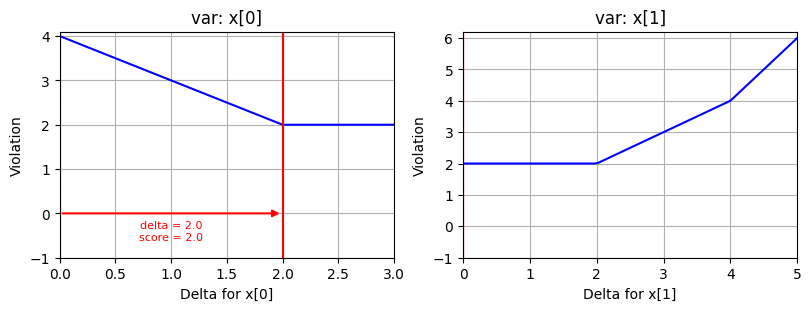

Update: x[0] = x[0] + 2.0
  New solution: [2. 0.], obj_val = -2.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [0. 0.], obj_val = inf

=== Iteration 2 ===
Violation functions:


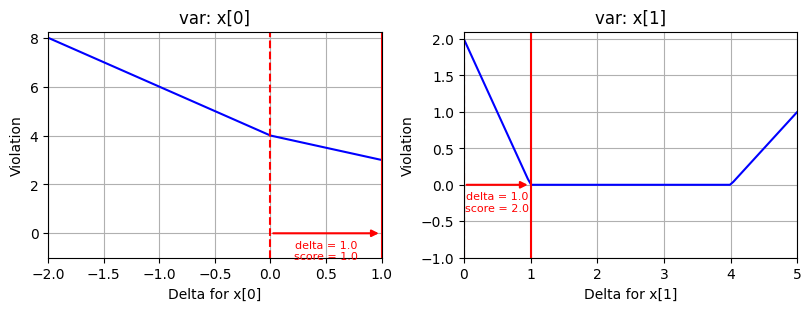

Update: x[1] = x[1] + 1.0
  New solution: [2. 1.], obj_val = -3.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 1.], obj_val = -3.0

=== Iteration 3 ===
Violation functions:


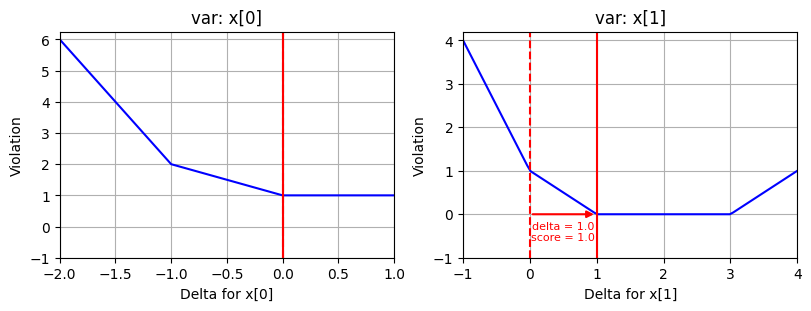

Update: x[1] = x[1] + 1.0
  New solution: [2. 2.], obj_val = -4.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 2.], obj_val = -4.0

=== Iteration 4 ===
Violation functions:


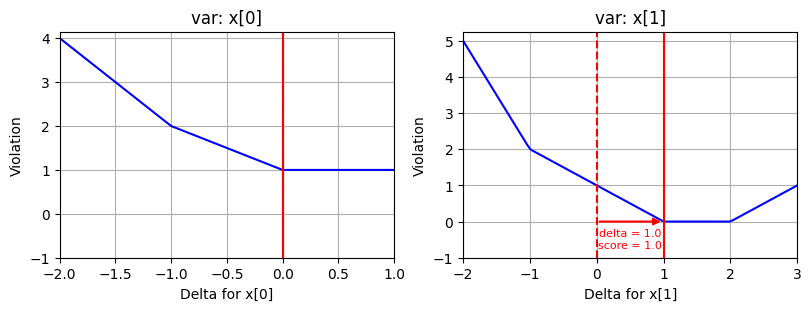

Update: x[1] = x[1] + 1.0
  New solution: [2. 3.], obj_val = -5.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 3.], obj_val = -5.0

=== Iteration 5 ===
Violation functions:


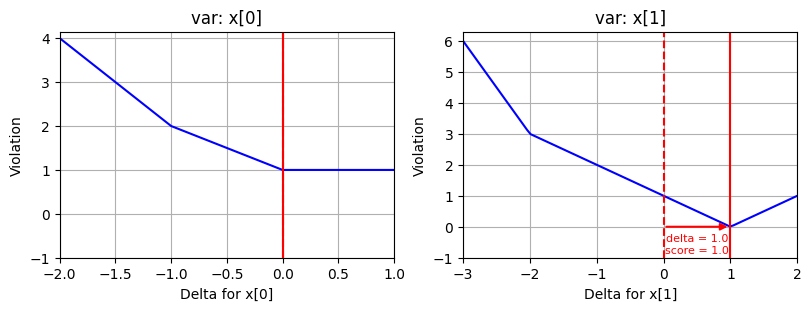

Update: x[1] = x[1] + 1.0
  New solution: [2. 4.], obj_val = -6.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 4.], obj_val = -6.0

=== Iteration 6 ===
Violation functions:


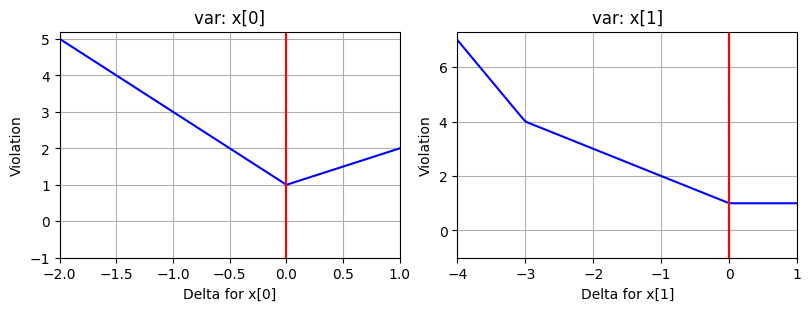

No variable update. Cannot continue. Done.


array([2., 4.])

In [11]:
# Run dense CPU version of feasibility jump for simple instance.
init_x = initialize_solution(SIMPLE_IP)
run_feasibility_jump_cpu_dense(SIMPLE_IP, init_x, max_num_steps=10)

Starting feasibility jump from initial solution:
  [0. 0.], obj_val = 0.0

=== Iteration 1 ===


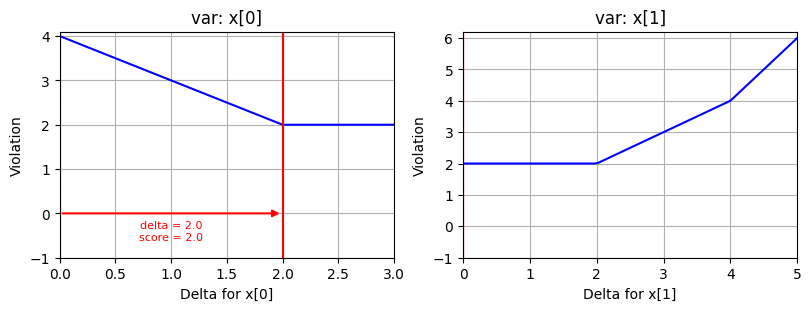

Update: x[0] = x[0] + 2.0
  New solution: [2. 0.], obj_val = -2.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [0. 0.], obj_val = inf

=== Iteration 2 ===


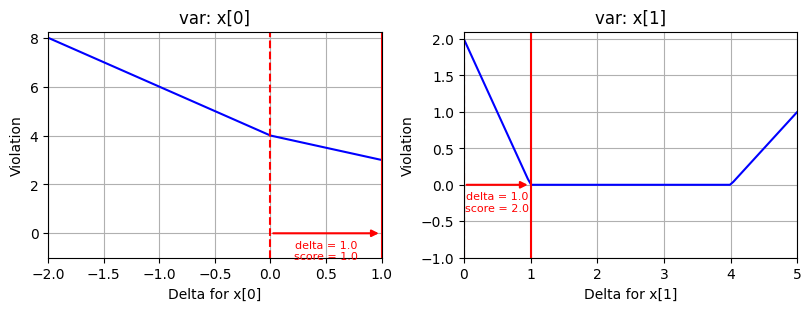

Update: x[1] = x[1] + 1.0
  New solution: [2. 1.], obj_val = -3.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 1.], obj_val = -3.0

=== Iteration 3 ===


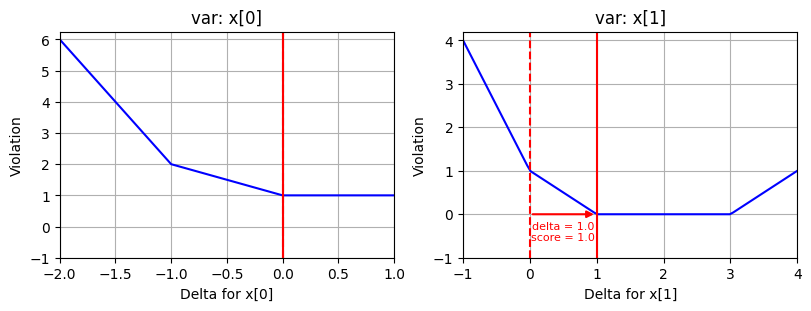

Update: x[1] = x[1] + 1.0
  New solution: [2. 2.], obj_val = -4.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 2.], obj_val = -4.0

=== Iteration 4 ===


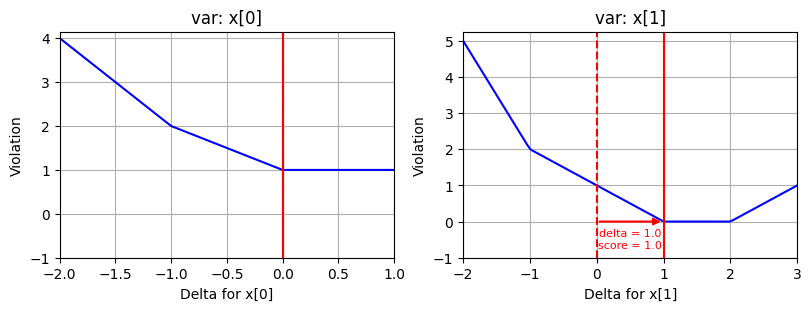

Update: x[1] = x[1] + 1.0
  New solution: [2. 3.], obj_val = -5.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 3.], obj_val = -5.0

=== Iteration 5 ===


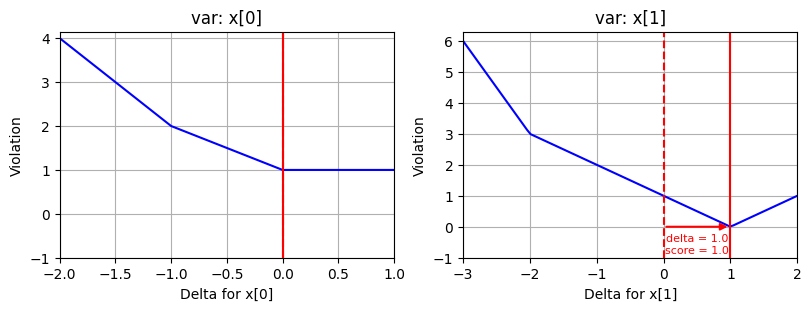

Update: x[1] = x[1] + 1.0
  New solution: [2. 4.], obj_val = -6.0
  New weights: [2. 1. 1. 1. 1.]
  Best feasible solution: [2. 4.], obj_val = -6.0

=== Iteration 6 ===


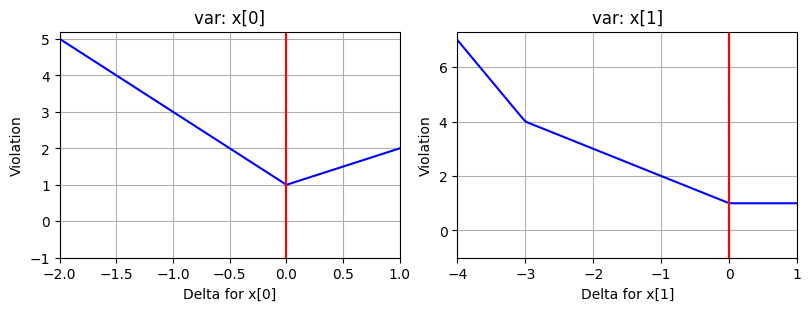

No variable update. Cannot continue. Done.


array([2., 4.])

In [12]:
# Run sparse CPU version of feasibility jump for simple instance.
init_x = initialize_solution(SIMPLE_IP)
run_feasibility_jump_cpu_sparse(SIMPLE_IP, init_x, max_num_steps=10)

# Cutting stock instances for benchmarking

We define some instances to evaluate implementation performance with scale. For purposes of the tutorial,
you do not need to look at the code (though you still need to run the cell.) The code below generates random cutting stock instances with fixed patterns. To
emulate some sparsity, we limit the number of items per pattern, or
equivalently, the number of nonzeros per column.

In [13]:
def generate_cutting_stock_instance(
    num_items: int,
    num_extra_patterns: int,
    max_item_types_per_pattern: int = 8,
    max_bin_width: int = 400,
    seed: int = 1234,
) -> IPInstance:
  """Generates a random instance for a simple cutting stock problem.

  We consider a cutting stock problem where the patterns are fixed. For a
  description, see https://en.wikipedia.org/wiki/Cutting_stock_problem, except
  that we generate a random set of patterns to choose from.

    min sum(x)
        Ax >= b
         x >= 0, integer

  where variables x_j indicates that we use pattern j x_j times.

  To emulate some sparsity, we limit the number of item types in each pattern.
  This implies that the number of nonzeros per column is bounded by
  `max_item_types_per_pattern`.

  Args:
    num_items: Number of items in the cutting stock problem, corresponding to
      the number of constraints.
    num_extra_patterns: Number of patterns beyond singleton patterns. The total
      number of variables will be num_items + num_extra_patterns.
    max_item_types_per_pattern: Maximum number of item types in each pattern.
      This bounds the number of nonzeros per column.
    seed: Seed for random number generator.

  Returns:
    An IPInstance corresponding to the generated instance.
  """
  np.random.seed(seed)

  min_item_width = 5
  max_item_width = 20
  min_demand = 5
  max_demand = 40

  # Generate widths and demands for each item.
  item_widths = np.random.randint(
      min_item_width, max_item_width + 1, size=num_items
  )
  item_demands = np.random.randint(min_demand, max_demand, size=num_items)

  # Add singleton patterns, each of which contains one item, for feasibility.
  singleton_patterns = np.eye(num_items, dtype=int)

  extra_patterns = []
  # Add random patterns by randomly adding items until capacity. We restrict to
  # a subset of item types per pattern, limited by `max_item_types_per_pattern`.
  for _ in range(num_extra_patterns):
    allowed_items = np.random.choice(
        num_items,
        size=min(max_item_types_per_pattern, num_items),
        replace=False,
    )
    # Generate a long random stream of items.
    min_width = item_widths[allowed_items].min()
    num_gen_items = int(max_bin_width / max(1, min_width)) + 1
    candidate_stream = np.random.choice(allowed_items, size=num_gen_items)

    # Cut off the stream at `max_bin_width`.
    cumulative_widths = np.cumsum(item_widths[candidate_stream])
    cutoff = np.searchsorted(cumulative_widths, max_bin_width, side='right')

    # Count the items in the array.
    pattern = np.bincount(candidate_stream[:cutoff], minlength=num_items)
    extra_patterns.append(pattern)

  # Shape is (num_vars (i.e. num_patterns), num_items).
  patterns = np.vstack([singleton_patterns, np.array(extra_patterns)])

  num_vars = len(patterns)

  # Construct constraint coefficient matrix A in sparse form.
  col_indices, row_indices = patterns.nonzero()
  data = -patterns[col_indices, row_indices]  # Negate since we use <=.
  A = scipy.sparse.csr_matrix(
      (data, (row_indices, col_indices)),
      shape=(patterns.shape[1], patterns.shape[0])
  )

  # Construct RHS, which are simply item demands (negated due to <=).
  rhs = -item_demands.astype(np.float64)

  # Objective function is to minimize total numbers of patterns used.
  obj_c = np.ones(num_vars, dtype=np.float64)

  # Define variable bounds. We assume problem is bounded.
  var_lb = np.zeros(num_vars, dtype=np.float64)
  var_ub = np.full(num_vars, 100, dtype=np.float64)

  return IPInstance(
      c=obj_c,
      A=A,
      b=rhs,
      var_lb=var_lb,
      var_ub=var_ub,
  )

# Benchmarking dense vs sparse implementations

Finally, we compare the performance of the dense and sparse implementations on CPU, highlighting the importance of sparsity. In fact, even when the matrix is significantly denser, the sparse implementation works well.

Benchmarking:   0%|          | 0/4 [00:00<?, ?it/s]

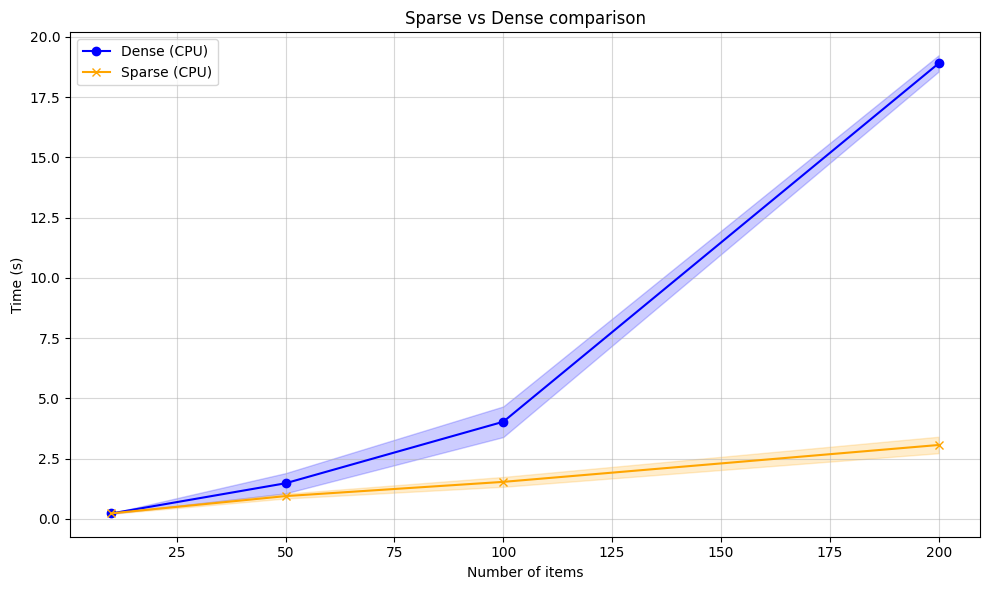

Benchmarking:   0%|          | 0/4 [00:00<?, ?it/s]

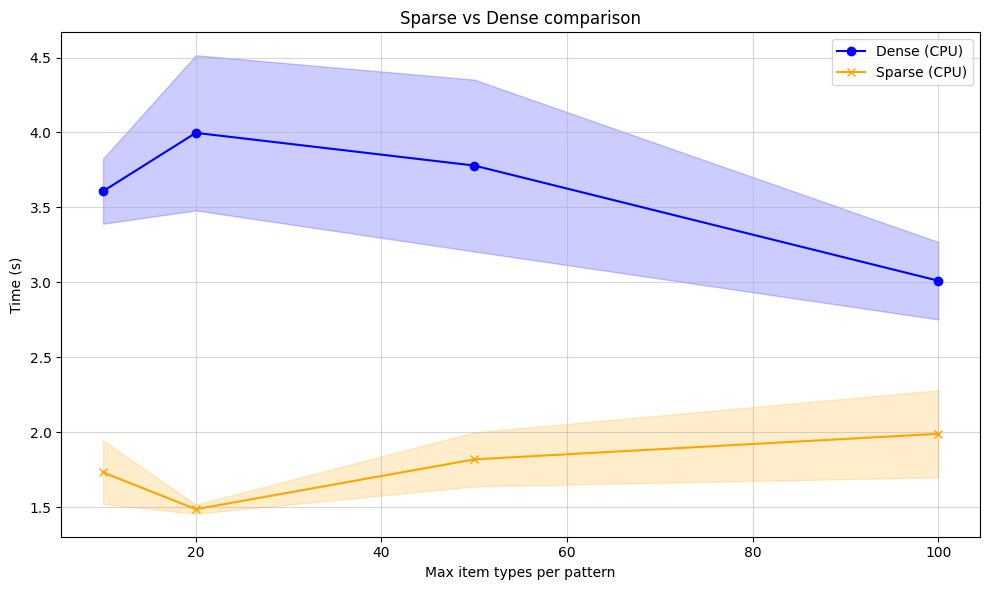

In [14]:
import gc
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm


def benchmark_execution(func, *args, **kwargs):
  """Runs a function for benchmarking."""
  start_time = time.perf_counter()
  solution = func(*args, **kwargs)
  end_time = time.perf_counter()
  return end_time - start_time, solution


def run_benchmark(
    mode: str,
    values_to_test: list,
    fixed_param: int,
    num_trials: int = 3,
    max_steps: int = 200,
    num_extra_patterns_ratio: float = 1.0,
    max_bin_width: int = 400,
    seed_offset: int = 1234,
):
  results = {
      'mode': mode,
      'values': values_to_test,
      'dense_mean': [],
      'dense_std': [],
      'sparse_mean': [],
      'sparse_std': [],
  }

  for val in tqdm(values_to_test, desc='Benchmarking'):

    if mode == 'size':
      n_items = val
      max_types = min(fixed_param, n_items)
    elif mode == 'density':
      n_items = fixed_param
      max_types = min(val, n_items)
    else:
      raise ValueError("mode must be 'size' or 'density'")

    n_patterns = int(n_items * num_extra_patterns_ratio)

    dense_times = []
    sparse_times = []

    for i in range(num_trials):
      seed = seed_offset + (val * 100) + i

      instance = generate_cutting_stock_instance(
          num_items=n_items,
          num_extra_patterns=n_patterns,
          max_item_types_per_pattern=max_types,
          max_bin_width=max_bin_width,
          seed=seed,
      )

      init_x = initialize_solution(instance)

      t_dense, solution = benchmark_execution(
          run_feasibility_jump_cpu_dense,
          instance=instance,
          init_x=init_x.copy(),
          max_num_steps=max_steps,
          plot_violation_fns=False,
          print_progress=False,
      )
      dense_times.append(t_dense)

      t_sparse, solution = benchmark_execution(
          run_feasibility_jump_cpu_sparse,
          instance=instance,
          init_x=init_x.copy(),
          max_num_steps=max_steps,
          plot_violation_fns=False,
          print_progress=False,
      )
      sparse_times.append(t_sparse)

    results['dense_mean'].append(np.mean(dense_times))
    results['dense_std'].append(np.std(dense_times))
    results['sparse_mean'].append(np.mean(sparse_times))
    results['sparse_std'].append(np.std(sparse_times))

  return results


def plot_benchmark_results(res):
  vals = np.array(res['values'])
  mode = res['mode']

  d_mean = np.array(res['dense_mean'])
  d_std = np.array(res['dense_std'])
  s_mean = np.array(res['sparse_mean'])
  s_std = np.array(res['sparse_std'])

  plt.figure(figsize=(10, 6))

  plt.plot(vals, d_mean, label='Dense (CPU)', marker='o', color='blue')
  plt.fill_between(
      vals, d_mean - d_std, d_mean + d_std, alpha=0.2, color='blue'
  )

  plt.plot(vals, s_mean, label='Sparse (CPU)', marker='x', color='orange')
  plt.fill_between(
      vals, s_mean - s_std, s_mean + s_std, alpha=0.2, color='orange'
  )

  plt.ylabel('Time (s)')
  plt.title('Sparse vs Dense comparison')
  if mode == 'size':
    plt.xlabel('Number of items')
  else:
    plt.xlabel('Max item types per pattern')

  plt.legend()
  plt.grid(True, which='both', ls='-', alpha=0.5)
  plt.tight_layout()
  plt.show()


results_size = run_benchmark(
    mode='size',
    values_to_test=[10, 50, 100, 200],
    fixed_param=8,  # max_item_types_per_pattern
)
plot_benchmark_results(results_size)

results_density = run_benchmark(
    mode='density',
    values_to_test=[10, 20, 50, 100],
    fixed_param=100, # num_items
    max_bin_width=50000,  # large bin to allow dense columns
)

plot_benchmark_results(results_density)

This concludes Part 1 of the tutorial! Parts 2 and 3 contain GPU implementations of this algorithm.